In [1]:
import time
import folium
import geopandas as gpd
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import requests
import pyrosm
import osmnx as ox
import random
import csv
import pickle
import numpy as np
import math
import datetime as dt
from haversine import haversine, Unit
from shapely.geometry import Point, box
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo 
from pyproj import Transformer
import scipy.stats as sps
import gpflow
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss


tqdm.pandas()
path = r'C:\Users\nial\OneDrive\ETH Zürich\Statslab 2024\Beijing'
os.chdir(path)

### 27.03 Calibration Analysis

In order to evaluate the hotspot scores, we will perform a calibration analysis as follows:

1. We will repeat the simulation process of Beijing data, but this time adding a column f(x) that tracks the 'true' normalised PM2.5 value before the Gaussian random noise is added. Note that the driver locations do not need to be re-simulated, only the PM2.5 measurements.
2. We will then re-run the hotspot detection methodology on this new dataset, and compute the new p values per tile.
3. Finally, we will compare the proportion of `f(x)` values exceeding the median per decile of p values. Hopefully it's a good result...

#### 0. Random helper functions

In [15]:
def reload_driver_trajectories():
    """
    Reload driver trajectories and measurement times from `Beijing_data_simulation`
    """

    all_times_cl = pd.read_csv("all_times_cl.csv")
    all_times_lp = pd.read_csv("all_times_lp.csv")

    all_times_cl.drop(columns=["Unnamed: 0"], inplace=True)
    all_times_lp.drop(columns=["Unnamed: 0"], inplace=True)

    all_times_cl["time"] = pd.to_datetime(all_times_cl["time"])
    all_times_lp["time"] = pd.to_datetime(all_times_lp["time"])

    return all_times_cl, all_times_lp

#### 1. Re-simulate the Beijing data

Simulate the measurements

In [16]:
all_times_cl, all_times_lp = reload_driver_trajectories()

# dataframe 1: China Life
df_cl           = pd.read_csv("China_Life.csv")

# dataframe 2: Longtan Park
df_lp           = pd.read_csv("Longtan_Park.csv")

df_temporal_usa = pd.read_csv("df_temporal_usa.csv")

In [9]:
def get_grid_point_geo(df: pd.DataFrame, point: tuple):
    """
    Retrieve nearest grid point to a (lon, lat) point.
    
    Input:
    df: contains the grid points in 'lon' and 'lat' (pd.DataFrame)
    point: lon, lat (tuple)

    Output:
    grid_centroid: grid point nearest (lon, lat)
    """
    # unpack tuples
    lon, lat = point
 
    # find nearest grid point
    lon_nearest = df.iloc[(df['lon']-lon).abs().argsort()[:1]]['lon'].tolist()
    lat_nearest = df.iloc[(df['lat']-lat).abs().argsort()[:1]]['lat'].tolist()

    return *lon_nearest, *lat_nearest

In [24]:
def simulate_pollution_row_geo(df, df_temporal_usa, row, sigma, alpha, beta, pgamma):
    """
    Simulate a PM2.5 measurement for a given row of all_times.

    Inputs:
    df: spatial PM2.5 profile (df_cl or df_lp)
    df_temporal_usa: US embassy data
    row: row from all_times dataframe
    sigma: Gaussian noise s.d.
    alpha: Gamma noise parameter
    beta: Gamma noise parameter
    pgamma: probability of injecting gamma noise

    Outputs:
    measurement: pm2.5 measurement
    """
    # fetch nearest centroid
    grid_lon, grid_lat = get_grid_point_geo(df=df, point=(row['lon'], row['lat']))

    # get base PM2.5 value
    base_pm25 = df['pm25'][(df['lon'] == grid_lon) & (df['lat'] == grid_lat)].values[0]
    base_pm25 = float(base_pm25)

    # fetch hourly multiplier
    rounded = row['time'].floor('h')
    date_part = rounded.date().strftime('%Y-%m-%d')
    day_part = rounded.day
    hour_part = rounded.hour
    multiplier = df_temporal_usa[(df_temporal_usa['Hour'] == hour_part) & (df_temporal_usa['Day'] == day_part)]['Multiplier']
    try: multiplier = multiplier.values[0]
    except IndexError: print(f"Multiplier: {multiplier}")
    
    # generate random noise
    gaussian = np.random.normal(loc=0,scale=sigma)
    uniform = np.random.uniform()

    # add Gamma noise with p=pgamma
    gamma = 0 if uniform >= pgamma else np.random.gamma(shape=alpha, scale=beta)

    # combine to get final PM2.5 value
    spatiotemporal  = base_pm25 * multiplier
    y               = spatiotemporal + gaussian + gamma
    
    return y, spatiotemporal , gamma

In [25]:
def simulate_pollution_geo(all_times, df, df_temporal_usa, sigma=1, alpha=5, beta=5, pgamma=0.05):
    """
    Simulate a PM2.5 measurement for every entry of all_times.

    Inputs:
    all_times: lon, lat, datetime combinations at which to simulate
    df: spatial PM2.5 profile (df_cl or df_lp)
    df_temporal_usa: US embassy data
    row: row from all_times dataframe
    sigma: Gaussian noise s.d.
    alpha: Gamma noise parameter
    beta: Gamma noise parameter
    pgamma: probability of injecting gamma noise

    Outputs:
    all_times: df with columns 'measurement' and 'gamma_noise' added
    """
    all_times[['measurement','spatiotemporal', 'gamma']] = all_times.apply(lambda row:simulate_pollution_row_geo(df, df_temporal_usa, row, sigma, alpha, beta, pgamma), axis=1, result_type='expand')
    
    return all_times

In [26]:
print("Simulating China Life...")
china_life_calibration = simulate_pollution_geo(all_times_cl, df_cl, df_temporal_usa)
china_life_calibration.to_csv("china_life_calibration.csv")

print("Simulating Longtan Park...")
longtan_park_calibration = simulate_pollution_geo(all_times_lp, df_lp, df_temporal_usa)
longtan_park_calibration.to_csv("longtan_park_calibration.csv")

Simulating China Life...
Simulating Longtan Park...


Apply data processing steps and normalise for background concentrations.

In [48]:
# read data from csv if necessary

def read_calibration_data():
    """
    Read calibration data from csv files.
    """
    china_life_calibration = pd.read_csv("china_life_calibration.csv", index_col=0)
    longtan_park_calibration = pd.read_csv("longtan_park_calibration.csv", index_col=0)

    china_life_calibration['time'] = pd.to_datetime(china_life_calibration['time'])
    longtan_park_calibration['time'] = pd.to_datetime(longtan_park_calibration['time'])

    return china_life_calibration, longtan_park_calibration

In [54]:
china_life_calibration, longtan_park_calibration = read_calibration_data()

In [51]:
def rolling_detrend(df: pd.DataFrame):
    """
    Compute PM2.5 baselines

    Input:
    df: dataframe in preprocessing sequence

    Output:
    df: dataframe with 15-minute, day and combined baselines
    """
    # compute baselines
    df_time = df.set_index('time')
    df_time.sort_index(inplace=True)
    df_time = df_time[['pm25']]
    df_time.drop_duplicates(inplace=True)
    baseline_15_min = df_time.rolling('15min').median()
    baseline_day = df_time.rolling('1D').median()

    # deduplicate times
    dupe_15_i = baseline_15_min.index.duplicated()
    dupe_day_i = baseline_day.index.duplicated()

    baseline_15_min = baseline_15_min[~dupe_15_i] 
    baseline_day = baseline_day[~dupe_day_i]

    # join data and baselines on time indices
    df = df.merge(baseline_15_min
                ,how='left'
                ,left_on='time'
                ,right_index=True
                ,suffixes=(None,'_baseline_15'))
    
    df = df.merge(baseline_day
                  , how='left'
                  , left_on='time'
                  , right_index=True
                  , suffixes=('_original','_baseline_day'))
    
    # subtract baselines from data
    df['pm25_detrended_15'] = df['pm25_original'] - df['pm25_baseline_15']
    df['pm25_detrended_day'] = df['pm25_original'] - df['pm25_baseline_day']
    df['pm25_detrended_comb'] = df['pm25_original'] - 0.5*\
        (df['pm25_baseline_15'] + df['pm25_baseline_day'])
    
    return df

In [43]:
def process_for_gp_flow(df: pd.DataFrame):
    """
    Preprocess the dataframe of observations ahead of the Gaussian processes flow.

    Inputs:
    df: dataframe output of simulate_pollution_geo()

    Outputs:
    df: processed dataframe
    """
    # retain unique entries
    df.drop_duplicates(inplace=True)

    # rename columns
    df.rename({'measurement':'pm25'}, axis='columns', inplace=True)

    # filter to month of interest
    df = df[\
        (df['time'] >= '2019-09-01') &\
        (df['time'] < '2019-10-01')]
    
    # count active drivers
    df['count_drivers'] = df.groupby('time')['time'].transform('count')

    # filter out outliers
    df = df[df['pm25'] <= 500]

    # compute detrended PM2.5 values
    df = rolling_detrend(df)

    # add column f_x
    df['f_x'] = df['spatiotemporal'] + df['gamma'] - df['pm25_baseline_15']

    return df

In [71]:
china_life_calibration_gp      = process_for_gp_flow(china_life_calibration)
longtan_park_calibration_gp    = process_for_gp_flow(longtan_park_calibration)

#china_life_calibration_gp.to_csv("china_life_calibration_gp.csv")
#longtan_park_calibration_gp.to_csv("longtan_park_calibration_gp.csv")

Finally, we also need to retrieve the tile ID of every observation. Recall that the tile IDs have already been assigned to each observation. Therefore, we can just match with those on latitude and longitude.

In [77]:
def fetch_tile_IDs(df: pd.DataFrame, df_tiles: pd.DataFrame) -> pd.DataFrame:
    """
    Add tile_id to df by matching latitude and longitude with df_tiles.

    Inputs:
    df: DataFrame containing 'lat' and 'lon' columns.
    df_tiles: DataFrame containing 'lat', 'lon', and 'tile_id' columns.

    Outputs:
    df: Original DataFrame with an added 'tile_id' column.
    """
    df_tiles_unique = df_tiles.drop_duplicates(subset=['lat', 'lon'])
    df = df.merge(df_tiles_unique[['lat', 'lon', 'tile_id']], on=['lat', 'lon'], how='left')
    return df

In [ ]:
# df_tiles_cl = pd.read_csv("atg_cl.csv")
# df_tiles_lp = pd.read_csv("atg_lp.csv")

china_life_calibration_gp = fetch_tile_IDs(china_life_calibration_gp, df_tiles_cl)
longtan_park_calibration_gp = fetch_tile_IDs(longtan_park_calibration_gp, df_tiles_lp)

china_life_calibration_gp.to_csv("china_life_calibration_gp.csv", index=False)
longtan_park_calibration_gp.to_csv("longtan_park_calibration_gp.csv", index=False)

In [2]:
china_life_calibration_gp = pd.read_csv("china_life_calibration_gp.csv")
longtan_park_calibration_gp = pd.read_csv("longtan_park_calibration_gp.csv")

#### Update: we now perform a train-test split for the calibration analysis

Select six random days as the test set and twenty four random days as the train set.
Fit model only to the training data, then evaluate calibration on the test data.

In [6]:
def train_test_split(df_gp: pd.DataFrame, n_test: int=6):
    """
    Split the data into training and test sets.
    
    Args:
        df_gp: dataframe output of process_for_gp_flow()
        n_test: number of days set aside for testing (default 6)

    Returns:
        df_train, df_test
    """
    # convert time to datetime
    df_gp['time'] = pd.to_datetime(df_gp['time'])

    # select n_test days for testing
    test_days = np.random.choice(30, n_test, replace=False)

    print(f"Test days: {test_days}")

    # filter to test days
    df_test = df_gp[df_gp['time'].dt.day.isin(test_days)]
    df_train = df_gp[~df_gp['time'].dt.day.isin(test_days)]

    return df_train, df_test

In [7]:
china_life_calibration_gp_train, china_life_calibration_gp_test = train_test_split(china_life_calibration_gp, n_test=6)
longtan_park_calibration_gp_train, longtan_park_calibration_gp_test = train_test_split(longtan_park_calibration_gp, n_test=6)

Test days: [ 9 26 23 19  6  4]
Test days: [22  8 24 17 18 14]


In [12]:
china_life_calibration_gp_train.to_csv("china_life_calibration_gp_train.csv", index=False)
china_life_calibration_gp_test.to_csv("china_life_calibration_gp_test.csv", index=False)
longtan_park_calibration_gp_train.to_csv("longtan_park_calibration_gp_train.csv", index=False)
longtan_park_calibration_gp_test.to_csv("longtan_park_calibration_gp_test.csv", index=False)

### 2. Re-apply the Gaussian process pipeline

We make spatially explicit normalised PM2.5 predictions on the new simulated data.

In [13]:
def calculate_pollution_levels(tiles_df):
    
    """ This function computes the median pollution level per tile (250m^2) and adds it as a variable """

    tile_stats = tiles_df.groupby("tile_id")["pm25_detrended_15"].agg(["mean", "std"]).reset_index()
    tiles_df = tiles_df.merge(tile_stats, on = "tile_id")
    tiles_df["pollution_level"] = tiles_df["mean"]/ tiles_df["std"]
    return tiles_df

In [14]:
def stratified_sampling(df, p_low, p_high, sample_frac_low, sample_frac_medium,
                        sample_frac_high, add_covariates, response, size_subsample):
    
    """ 
        This function subsamples size_subsample number of observations while oversampling low and high pollution
        area, which are determined via p_low, p_high (percentiles of median pollution per tile). Sample_frac determine
        the composition of the size_subsample observations regarding low, medium and high pollution. Add covariates adds
        further covariates from osm and response chooses the response variable. Return X, Y for GP.
    """
    
    # Calculate the pollution levels for each tile
    df_poll = calculate_pollution_levels(df)
    df_poll = df_poll.dropna(subset=["pollution_level"])

    # Calculate the percentile pollution levels and split into groups
    p_low_value = np.percentile(df_poll["pollution_level"], p_low)
    p_high_value = np.percentile(df_poll["pollution_level"], p_high)

    low_pollution_tiles = df_poll[df_poll["pollution_level"] < p_low_value]
    medium_pollution_tiles = df_poll[(df_poll["pollution_level"] >= p_low_value) & (df_poll["pollution_level"] < p_high_value)]
    high_pollution_tiles = df_poll[df_poll["pollution_level"] > p_high_value]

    # Determine the sample size for each stratum
    total_sample_size = size_subsample * (sample_frac_low + sample_frac_medium + sample_frac_high)
    low_pollution_sample_size = int(total_sample_size * sample_frac_low)
    medium_pollution_sample_size = int(total_sample_size * sample_frac_medium)
    high_pollution_sample_size = int(total_sample_size * sample_frac_high)

    # Use stratified random sampling to select samples from each stratum
    low_pollution_sample = low_pollution_tiles.sample(n=low_pollution_sample_size, replace=False)
    medium_pollution_sample = medium_pollution_tiles.sample(n=medium_pollution_sample_size, replace=False)
    high_pollution_sample = high_pollution_tiles.sample(n=high_pollution_sample_size, replace=False)

    # Combine the samples from each stratum to obtain the final sample
    final_sample = pd.concat([low_pollution_sample, medium_pollution_sample, high_pollution_sample])
    
    # Get the X and Y arrays
    if add_covariates == False:
        X = final_sample[["lon", "lat"]].to_numpy()
    else: 
        X= final_sample[["lon", "lat", "industrial", "major.road", "res.road"]].to_numpy()
    
    Y = final_sample[[response]].to_numpy()
    
    return X, Y

In [15]:
def fitting_process(response, iterations, p_low, p_high, sample_frac_low, sample_frac_medium, sample_frac_high,
                    add_covariates, size_subsample, grid, independence, df_name:str="atg_cl_gamma", grid_name: str="df_cl",
                    weighted_fit=False):
    
    """ 
        This function fits and evaluates the models on the test points.
        
        INPUTS:
        response:       detrended pm 2.5 (either "pm25_detrended_15" or "pm25_detrended_day")
        iterations:     number of iterations (total number of GP fitted)
        p_low:          lower cut-off in terms of percentile of median pollution level per tile for the stratified sampling (in [0,100])
        p_high:         higher cut-off in terms of percentile of median pollution level per tile for the stratified sampling (in [0,100])
        sample_frac_low, sample_frac_medium, sample_frac_high: 
                        perc. of obs from low, medium and high pollution levels (sum to 1)
        add_covariates: use street variables in estimation (True or False)
        size_subsample: number of observations per model
        grid:           sqrt(desired number of test observations)
        independence:   if one thinks that the models are independent (e.g. because of subsampling). This affects the variance
                        of the predictions (True or False)
        df_name:        name of DataFrame in working directory containing PM2.5 measurements (str)
        grid_name:      name of DataFrame in working directory containing test grid coords (str)
        weighted_fit:   weight model predictions by their inverse variances? (True or False)
                      
        OUTPUTS:
        (1) A dictionary that contains all the fitted models which can be accesses using the time bracket keys 
            (e.g. dict["06:00:00"])
        (2) A dictionary that contains all the predicted values on the test observations which ... " ------- "
        (3) A dictionary that contains all the predicted variances on the test observations which ... " ------- " 
        (4) A data frame that contains latitude, longitude, predicted values, predicted variances and z values 
            for the test points.
           
    """
    # Read in PM2.5 measurements
    df = pd.read_csv(f"{df_name}.csv")

    # Read in dataframe containing test grid
    grid = pd.read_csv(f"{grid_name}.csv")

    # Define the detrended pm25 median
    median_pm25 = np.median(df[response])

    # Depending on the processing, you may need to adjust the datetime variable here so you just have the daytime.
    df["time"] = df["time"].str.rstrip("Z")
    df["time"] = pd.to_datetime(df["time"]).dt.time

    # Initialize empty dictionaries to save models
    models_dict = {}
    percentage_bracket = {}

    # Number of iterations
    num_iterations = iterations
    
    # To run the results without time brackets (just one bracket). Take one random starting time and then adapt the 
    # code below to check if the obersvations is in range(bracket.hour, bracket.hour+23). Do not forget to change it back.
    brackets = [pd.to_datetime("00:00:00").time()]
    
    # Run the ensemble for all brackets seperately
    for bracket in brackets:
        print(f"Bracket: {bracket}")

        # Filter the data for the current bracket & compute percentage of observations in this bracket
        # df_bracket = df[df["datetime"].apply(lambda x: x.hour in range(bracket.hour, bracket.hour+1))]
        df_bracket = df[df["time"].apply(lambda x: x.hour in range(bracket.hour, bracket.hour+24))]
        percentage_bracket[str(bracket)] = len(df_bracket)/len(df)
        print(f"Percentage in Bracket: {100 * len(df_bracket)/len(df)}")
        
        # Initialize a list to save models for the current bracket
        models = []
        
        # Start the timer
        start_time = time.time()

        # Only run num_iteration / number of brackets per bracket as we take num_iterations to be the total number of fitted models
        for i in range(int(num_iterations/len(brackets))):
            print(f"Iteration {i+1}")

            # Sample data
            X, Y = stratified_sampling(df=df_bracket, p_low=p_low, p_high=p_high, sample_frac_low=sample_frac_low,
                                       sample_frac_medium=sample_frac_medium, sample_frac_high=sample_frac_high,
                                       add_covariates=add_covariates, response=response,
                                       size_subsample=size_subsample)
            
            # augment with off-road zeroes
            # this does not restrain the lengthscale as I thought it would
            # X, Y = augment_XY(df, size_subsample, X, Y)

            # Initiate model and train it. The optimization sets l = 0, which creates algebraic issues so we set it to 0.1. 
            k = gpflow.kernels.Exponential()
            model = gpflow.models.GPR((X, Y), kernel=k)
            opt = gpflow.optimizers.Scipy()
            opt.minimize(model.training_loss, model.trainable_variables)
            # model.kernel.lengthscales.assign(0.1)  
            gpflow.utilities.print_summary(model, "notebook")

            # Save the model
            models.append(model)
            
            # Check if it's the first iteration and compute time taken for first iteration and extrapolate 
            if i == 0:
                elapsed_time = time.time() - start_time
                total_time = elapsed_time * num_iterations / 60

                # Print the predicted run-time
                print(f"Predicted total time for fitting the models: {total_time:.2f} minutes")

        # Save the model into the dict so we can access using bracket name
        models_dict[str(bracket)] = models
        
    # Now once we have ran all the models, we evaluate them to create the predictions on the grid of test points.

    # Create X_test
    x_s = grid['lon'].unique()
    y_s = grid['lat'].unique()
    x_grid, y_grid = np.meshgrid(x_s, y_s)
    X_test = np.column_stack((x_grid.ravel(), y_grid.ravel()))

    # Initialize empty dictionaries
    mean_values_dict = {}
    var_values_dict = {}

    # Loop through models_dict
    for bracket, models in models_dict.items():
        print(f"Evaluating models for bracket: {bracket}")

        # Initialize empty arrays
        mean_values = np.zeros((len(models), X_test.shape[0]))
        var_values = np.zeros((len(models), X_test.shape[0]))

        # Loop over each GP model and compute its predictions on the test points
        for i, model in enumerate(models):
            print(f"Iteration {i+1}")
            mean, var = model.predict_f(X_test)  
            mean = np.squeeze(mean.numpy())
            var = np.squeeze(var.numpy())
            mean_values[i, :] = mean
            var_values[i, :] = var

        # Compute the ensemble mean and variance by taking the average of the predicted values across all GP models
        if weighted_fit:
            inv_vars = 1 / var_values
            ensemble_var = (1 / np.sum(inv_vars, axis=0))
            ensemble_mean = ensemble_var * np.sum(mean_values * inv_vars, axis=0)

        else:
            ensemble_mean = np.mean(mean_values, axis=0)
            if independence == True:
                ensemble_var = np.mean(var_values, axis=0)
            else:
                ensemble_var = np.mean(var_values, axis=0) + np.mean((mean_values - ensemble_mean)**2, axis=0)

        # Save the mean and variance values in the respective dictionary
        mean_values_dict[str(bracket)] = ensemble_mean
        var_values_dict[str(bracket)] = ensemble_var
        
    # Initialize combined mean and variance arrays
    combined_mean = np.zeros(X_test.shape[0])
    combined_variance = np.zeros(X_test.shape[0])

    # Loop through the mean and variance dictionaries for each bracket
    total_weight = 0
    for bracket in brackets:

        # Get the respective mean and variance values
        mean_values_bracket = mean_values_dict[str(bracket)]
        var_values_bracket = var_values_dict[str(bracket)]

        # Accumulate the mean values
        combined_mean += mean_values_bracket*percentage_bracket[str(bracket)]

        # Accumulate the variances
        combined_variance += var_values_bracket*percentage_bracket[str(bracket)]
        
        # Accumulate the weights (if they do not sum to 1 as the brackets are not exhaustive, i.e. there are observations
        # that are not contained in any bracket)
        total_weight += percentage_bracket[str(bracket)]
        
    # Divide by the total weight to get the overall predicted values and predicted variances
    combined_mean /= total_weight
    combined_variance /= total_weight
    
    # Compute the z-values
    z_val = (combined_mean-median_pm25)/np.sqrt(combined_variance)

    # Construct csv to return
    df_res = pd.DataFrame({"lon": X_test[:,0].tolist(), "lat": X_test[:,1].tolist(),
                           "predicted_value": combined_mean, "predicted_variance": combined_variance,
                           "z_val": z_val})
        
    # Return the objects
    return models_dict, mean_values_dict, var_values_dict, df_res

In [16]:
# Path to data
save = True
n_iter = 100
np.random.seed(42)

# Fit and evaluate models
_, _, _, china_life_calibration_gp_results = fitting_process(response = "pm25_detrended_15", iterations = n_iter,
                                                                     p_low = 20, p_high = 80,
                                                                     sample_frac_low = 0.3, sample_frac_high = 0.3,
                                                                     sample_frac_medium = 0.4, add_covariates = False,
                                                                     size_subsample = 2000, grid = 200, independence = False
                                                                     , weighted_fit=False, df_name='china_life_calibration_gp_train', grid_name='df_cl')

if save:
    china_life_calibration_gp_results.to_csv("china_life_calibration_gp_train_results.csv", index = False)


# Fit and evaluate models
_, _, _, longtan_park_calibration_gp_results = fitting_process(response = "pm25_detrended_15", iterations = n_iter,
                                                                     p_low = 20, p_high = 80,
                                                                     sample_frac_low = 0.3, sample_frac_high = 0.3,
                                                                     sample_frac_medium = 0.4, add_covariates = False,
                                                                     size_subsample = 2000, grid = 200, independence = False
                                                                     , weighted_fit=False, df_name='longtan_park_calibration_gp_train', grid_name='df_lp')

if save:
    longtan_park_calibration_gp_results.to_csv("longtan_park_calibration_gp_train_results.csv", index = False)


Bracket: 00:00:00
Percentage in Bracket: 100.0
Iteration 1


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.86862
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00935997
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,36.9091


Predicted total time for fitting the models: 72.50 minutes
Iteration 2


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.77314
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00884323
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,51.2253


Iteration 3


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.86362
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0121296
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.9739


Iteration 4


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.21094
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0133883
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.11


Iteration 5


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,5.00334
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00689876
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,48.5283


Iteration 6


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,12.3772
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.07943e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.7361


Iteration 7


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.20281
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00553557
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.5936


Iteration 8


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,17.7966
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.28807e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.2721


Iteration 9


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.63754
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00552969
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.9381


Iteration 10


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.95348
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00455785
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.3702


Iteration 11


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.8614
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0192379
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.2728


Iteration 12


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,12.0849
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.62315e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.013


Iteration 13


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.96493
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00549771
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.1486


Iteration 14


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.94655
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00360842
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.2916


Iteration 15


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.65017
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0101286
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,53.1447


Iteration 16


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.42923
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0114369
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,48.45


Iteration 17


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,15.5832
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.50385e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.0002


Iteration 18


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.67662
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0157871
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.1086


Iteration 19


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,12.6233
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.40399e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.6211


Iteration 20


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.62836
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0128512
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.5084


Iteration 21


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.82816
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00767073
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.0643


Iteration 22


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.34751
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0178919
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,53.212


Iteration 23


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.04987
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00463693
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.6004


Iteration 24


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.1613
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0111999
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.8171


Iteration 25


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,12.2246
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.10328e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.2356


Iteration 26


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.32036
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0254442
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.8721


Iteration 27


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.04036
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0178299
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,44.7357


Iteration 28


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,11.0212
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.05532e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.7315


Iteration 29


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.5036
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.90934e-05
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.6359


Iteration 30


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.81817
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0159547
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.193


Iteration 31


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.93402
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0100326
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,39.4941


Iteration 32


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.75689
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0048374
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.3949


Iteration 33


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.20767
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0126307
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,64.0399


Iteration 34


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.00155
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0209894
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.2996


Iteration 35


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.99967
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00718903
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.0771


Iteration 36


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.71556
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0100436
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.5687


Iteration 37


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.78411
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00572051
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.0418


Iteration 38


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.61058
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00628497
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.5311


Iteration 39


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.25195
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00460025
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.3877


Iteration 40


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.92429
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00975551
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.4688


Iteration 41


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.45348
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00429603
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.2751


Iteration 42


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.06009
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00668267
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.4337


Iteration 43


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.06535
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.040499
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,51.6484


Iteration 44


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.09581
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00729855
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,42.1928


Iteration 45


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.68883
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0044089
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,37.3239


Iteration 46


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.17013
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00862662
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.3307


Iteration 47


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.51536
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0214223
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.6827


Iteration 48


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.14092
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00666328
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.2464


Iteration 49


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.95096
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00578472
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.1903


Iteration 50


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,30.8074
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.96862e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,21.0005


Iteration 51


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.74861
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00488029
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.5962


Iteration 52


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.66511
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00230819
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,56.4775


Iteration 53


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,5.93062
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0134157
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.9412


Iteration 54


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,12.5745
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.92617e-08
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.825


Iteration 55


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.01502
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00335325
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,36.9373


Iteration 56


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.47181
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00694451
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.3569


Iteration 57


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.75031
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0111678
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.8354


Iteration 58


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.84454
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00827226
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,48.4437


Iteration 59


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.17397
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0204932
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.4175


Iteration 60


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.5087
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.94021e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,48.6518


Iteration 61


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.38781
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00706874
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,60.7144


Iteration 62


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,5.22699
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0242819
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.1887


Iteration 63


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.329
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6.06064e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.1258


Iteration 64


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.32748
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0160358
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.4932


Iteration 65


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.54998
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0138731
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,44.6326


Iteration 66


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.23233
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00820043
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.7578


Iteration 67


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.69716
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00380846
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.3996


Iteration 68


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.9478
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.98443e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.2199


Iteration 69


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.55118
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00232671
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.7198


Iteration 70


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.83145
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.014493
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.9815


Iteration 71


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.99571
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00497186
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,44.3429


Iteration 72


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.8789
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00691736
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.6644


Iteration 73


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.24106
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00413365
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.8199


Iteration 74


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.64552
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00459292
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.6131


Iteration 75


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.79288
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0110653
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,64.91


Iteration 76


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,14.5507
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.32436e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,56.0429


Iteration 77


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.43489
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00742492
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.7123


Iteration 78


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.5185
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0207923
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.7516


Iteration 79


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.37454
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0329112
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,48.7253


Iteration 80


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,14.9024
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.44418e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,40.3871


Iteration 81


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.99043
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0133387
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.9541


Iteration 82


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.08963
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00446984
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,42.4484


Iteration 83


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,4.32749
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00364769
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.8734


Iteration 84


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.36349
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00398646
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.7708


Iteration 85


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.7577
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.47383e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.9691


Iteration 86


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.37251
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00949212
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.633


Iteration 87


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.25328
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00407842
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.4139


Iteration 88


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.49548
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00634007
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.8727


Iteration 89


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,11.8095
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.8455e-06
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,37.0937


Iteration 90


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.67555
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0216543
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,41.4513


Iteration 91


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.1027
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0118551
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.9493


Iteration 92


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.56825
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00921992
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.2898


Iteration 93


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.56579
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0131631
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.2042


Iteration 94


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,5.75343
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0101074
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.5832


Iteration 95


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,18.0098
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.26023e-07
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.7465


Iteration 96


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.5245
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0035704
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.2914


Iteration 97


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,8.64842
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0472983
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,56.679


Iteration 98


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,18.1406
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.6256e-08
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.9079


Iteration 99


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.34282
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00709507
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.3199


Iteration 100


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,3.36579
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00779616
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.8958


Evaluating models for bracket: 00:00:00
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iterati

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,132.344
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0421228
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,64.9598


Predicted total time for fitting the models: 181.39 minutes
Iteration 2


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,67.4634
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0150181
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,56.5568


Iteration 3


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,111.023
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0362577
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.9316


Iteration 4


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,139.373
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0444526
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.3291


Iteration 5


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,130.532
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0610002
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.8346


Iteration 6


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,195.041
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0515498
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,60.7278


Iteration 7


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,162.802
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0224348
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.7758


Iteration 8


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,78.0008
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0308958
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.7335


Iteration 9


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,93.9167
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0252244
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,53.4535


Iteration 10


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,118.271
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0406533
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.3228


Iteration 11


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,101.713
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0420082
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.9894


Iteration 12


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,192.458
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0469758
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,59.2568


Iteration 13


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,98.5165
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0227733
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,69.4535


Iteration 14


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,169.392
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0486341
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.6345


Iteration 15


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,65.0985
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0177843
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.221


Iteration 16


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,164.213
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0581744
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.4179


Iteration 17


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,112.014
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.036748
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,59.7358


Iteration 18


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,71.7706
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0243232
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.431


Iteration 19


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,77.8799
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0133867
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,53.7406


Iteration 20


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,165.981
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0507466
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.3488


Iteration 21


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,79.7561
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0233546
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.9897


Iteration 22


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,90.6716
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0353321
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,46.5389


Iteration 23


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,75.0381
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0157555
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.8722


Iteration 24


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,58.3566
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0122778
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.8385


Iteration 25


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,100.207
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0202805
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.5328


Iteration 26


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,114.188
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0344785
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,65.9393


Iteration 27


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,106.443
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0362508
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,51.02


Iteration 28


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,98.832
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0326779
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.9092


Iteration 29


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,65.3761
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.011539
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,48.711


Iteration 30


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,139.973
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0273294
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.9661


Iteration 31


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,98.1762
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0340054
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,59.5008


Iteration 32


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,68.27
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0181333
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.6044


Iteration 33


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,61.3906
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0148102
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.444


Iteration 34


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,198.774
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.060854
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.1084


Iteration 35


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,87.428
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0206554
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,63.3349


Iteration 36


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,70.2352
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0199119
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.6806


Iteration 37


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,134.593
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0422769
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,63.5426


Iteration 38


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,146.28
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0412553
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,51.7035


Iteration 39


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,145.831
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0430731
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,68.6836


Iteration 40


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,110.588
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.028385
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.9815


Iteration 41


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,96.2733
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.026624
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.2132


Iteration 42


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,83.8624
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0217941
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,51.3343


Iteration 43


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,127.066
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0372416
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,63.5362


Iteration 44


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,50.2235
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00802625
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.9604


Iteration 45


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,91.2794
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0273922
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,45.6825


Iteration 46


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,95.2034
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0263416
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.6908


Iteration 47


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,82.1733
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0228682
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,63.7522


Iteration 48


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,94.5157
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0205158
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,43.6798


Iteration 49


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,130.636
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0344257
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,53.5988


Iteration 50


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,70.9217
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0220655
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.6649


Iteration 51


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,45.3919
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.010735
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.0374


Iteration 52


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,105.808
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0310045
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.7617


Iteration 53


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,97.2316
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0430988
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.7158


Iteration 54


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,81.8961
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0195681
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.3532


Iteration 55


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,85.2423
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0272696
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,60.254


Iteration 56


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,70.039
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0172158
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.6007


Iteration 57


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,76.2286
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0239985
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.6695


Iteration 58


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,117.375
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0378584
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.2487


Iteration 59


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,95.3111
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0251357
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.3003


Iteration 60


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,112.017
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0292516
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,60.7182


Iteration 61


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,112.274
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0396182
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.767


Iteration 62


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,124.004
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0329383
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.6455


Iteration 63


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,142.508
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0446529
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,64.1324


Iteration 64


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,83.6237
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0206448
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,53.0163


Iteration 65


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,90.1591
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0326734
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,51.2209


Iteration 66


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,107.451
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0359706
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,65.9253


Iteration 67


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,138.086
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0349984
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,59.8912


Iteration 68


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,97.4831
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0273778
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.672


Iteration 69


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,102.419
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0244675
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,72.2138


Iteration 70


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,120.033
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.040548
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.0865


Iteration 71


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,148.309
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0508748
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.8736


Iteration 72


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,97.468
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0338372
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,65.2706


Iteration 73


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,55.8686
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0144158
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,50.7061


Iteration 74


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,118.492
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0409249
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,69.2932


Iteration 75


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,185.762
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0374243
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.963


Iteration 76


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,132.871
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0487052
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.3203


Iteration 77


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,80.8332
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0274835
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.597


Iteration 78


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,80.4738
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0200752
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.8333


Iteration 79


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,114.605
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0313163
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,47.5927


Iteration 80


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,53.6063
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.012391
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,52.8678


Iteration 81


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,58.763
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0171787
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,59.0113


Iteration 82


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,68.294
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.00946074
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,67.6405


Iteration 83


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,156.347
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0429706
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.8296


Iteration 84


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,78.6195
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0215623
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.344


Iteration 85


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,149.357
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0411315
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,56.1486


Iteration 86


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,136.658
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.033423
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.7775


Iteration 87


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,119.788
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0378053
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,64.7012


Iteration 88


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,69.1909
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0165719
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,57.5722


Iteration 89


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,177.019
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0499753
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,55.2731


Iteration 90


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,111.857
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0324822
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,62.0962


Iteration 91


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,102.678
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0222186
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,64.5108


Iteration 92


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,115.803
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0396825
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.0468


Iteration 93


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,97.6301
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0316717
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,61.461


Iteration 94


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,104.591
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0303046
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,65.7434


Iteration 95


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,111.115
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0275928
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,60.691


Iteration 96


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,145.2
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0201376
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,60.2652


Iteration 97


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,92.0044
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.017719
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,54.2193


Iteration 98


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,77.7047
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0212926
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,49.0522


Iteration 99


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,110.052
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0357199
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.8162


Iteration 100


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,106.792
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.035825
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,58.3417


Evaluating models for bracket: 00:00:00
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iterati

In [ ]:
china_life_calibration_gp_results['p_value'] = sps.norm.cdf(china_life_calibration_gp_results['z_val'])
longtan_park_calibration_gp_results['p_value'] = sps.norm.cdf(longtan_park_calibration_gp_results['z_val'])
china_life_calibration_gp_results.head()

#### 3. Calibration analysis

Finally, we will merge the tilewise prediction results with the observed data to calculate the proportion of f_x observations exceeding the median in each p_value decile.

In [108]:
# step 1. get tile IDs for the results

china_life_calibration_gp_results['tile_id'] = china_life_calibration_gp_results.index
longtan_park_calibration_gp_results['tile_id'] = longtan_park_calibration_gp_results.index

In [4]:
# step 2. function to get exceedance proportions per decile of p-values
def calibration_analysis(df_gp_results: pd.DataFrame, df_observed_measurements: pd.DataFrame, min_n_measurements: int=0, overall_median: float= None) -> pd.DataFrame:
    """
    Report exceedance proportions per decile of p-values.

    Args:
        df_gp_results: contains p-values and tile IDs
        df_observed_measurements: contains observed measurements and tile IDs
        min_n_measurements: minimum number of measurements per tile to be included in the analysis
        overall_median: overall median of observed measurements to compute exceedance proportions

    Returns:
        df_deciles: contains deciles of p-values and exceedance proportions
    """
    if 'tile_id' not in df_gp_results.columns:
        print("'tile_id' not found in df_gp_results. Adding it as index.")
        df_gp_results['tile_id'] = df_gp_results.index

    # Compute overall median of observed measurements
    if overall_median is None:
        print("Computing overall median of observed measurements...")
        print("This line should not run in a train-test split situation, since then the median is specified by the train observations...")
        overall_median = np.median(df_observed_measurements['pm25_detrended_15'])

    tile_counts = df_observed_measurements['tile_id'].value_counts().reset_index()
    tile_counts.columns = ['tile_id', 'n_measurements']

    # Merge with df_gp_results
    df_gp_results = df_gp_results.merge(tile_counts, on='tile_id', how='left')

    # Fill any missing counts with 0 (if there are tile_ids in df_gp_results not in df_observed_measurements)
    df_gp_results['n_measurements'] = df_gp_results['n_measurements'].fillna(0).astype(int)

    # Filter out tiles with fewer than min_n_measurements
    df_gp_results = df_gp_results[df_gp_results['n_measurements'] >= min_n_measurements]

    # Merge datasets on tile_id to associate each measurement with its p-value
    merged_df = df_observed_measurements.merge(df_gp_results[['tile_id', 'p_value']], on='tile_id', how='left')

    bins = np.arange(0, 1.1, 0.1)  # [0, 0.1, 0.2, ..., 1.0]
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins) - 1)]
    
    # Assign p-values to fixed decile bins
    merged_df['p_value_decile'] = pd.cut(merged_df['p_value'], bins=bins, labels=labels, include_lowest=True)

    # Compute exceedance proportions per fixed decile
    exceedance_proportions = (
        merged_df.groupby('p_value_decile')
        .apply(lambda g: (g['f_x'] > overall_median).mean())
        .reset_index(name='exceedance_proportion')
    )

    return exceedance_proportions

In [135]:
exceedance_proportions_cl = calibration_analysis(china_life_calibration_gp_results, china_life_calibration_gp)
exceedance_proportions_lp = calibration_analysis(longtan_park_calibration_gp_results, longtan_park_calibration_gp)

C:\Users\nial\AppData\Local\Temp\ipykernel_37604\970319302.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby('p_value_decile')
C:\Users\nial\AppData\Local\Temp\ipykernel_37604\970319302.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['f_x'] > overall_median).mean())
C:\Users\nial\AppData\Local\Temp\ipykernel_37604\970319302.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fa

In [137]:
china_life_calibration_gp_results.columns

Index(['lon', 'lat', 'predicted_value', 'predicted_variance', 'z_val',
       'p_value', 'tile_id'],
      dtype='object')

In [136]:
exceedance_proportions_cl

,p_value_decile,exceedance_proportion
0,0.0-0.1,NaN
1,0.1-0.2,NaN
2,0.2-0.3,0.085593
3,0.3-0.4,0.098074
4,0.4-0.5,0.143307
5,0.5-0.6,0.211030
6,0.6-0.7,0.588482
7,0.7-0.8,0.788430
8,0.8-0.9,0.816926
9,0.9-1.0,NaN


In [127]:
exceedance_proportions_lp

,p_value_decile,exceedance_proportion
0,0.0-0.1,NaN
1,0.1-0.2,0.081421
2,0.2-0.3,0.095697
3,0.3-0.4,0.142365
4,0.4-0.5,0.236149
5,0.5-0.6,0.264706
6,0.6-0.7,0.353473
7,0.7-0.8,0.580624
8,0.8-0.9,0.642889
9,0.9-1.0,0.833798


### 3.b) Calibration analysis with train-test split

#### Compute the empirical calibration

In [29]:
china_life_calibration_gp_train.head()

,lat,lon,time,pm25_original,spatiotemporal,gamma,count_drivers,pm25_baseline_15,pm25_baseline_day,pm25_detrended_15,pm25_detrended_day,pm25_detrended_comb,f_x,tile_id
0,39.923893,116.407098,2019-09-30 21:23:10,73.846912,74.897615,0.0,2,74.800277,82.532688,-0.953366,-8.685776,-4.819571,0.097338,6095
1,39.923894,116.407001,2019-09-30 21:23:11,71.803465,74.897615,0.0,2,74.795274,82.532173,-2.991808,-10.728708,-6.860258,0.102341,6095
2,39.923894,116.406903,2019-09-30 21:23:12,75.512803,74.897615,0.0,2,74.785495,82.531812,0.727308,-7.019009,-3.145851,0.112120,6095
3,39.923894,116.406805,2019-09-30 21:23:13,76.390421,74.897615,0.0,2,74.788806,82.531526,1.601614,-6.141106,-2.269746,0.108809,6094
4,39.923895,116.406708,2019-09-30 21:23:14,74.757379,74.897615,0.0,2,74.785495,82.531526,-0.028116,-7.774147,-3.901131,0.112120,6094


In [2]:
# to examine the calibration with the train-test split, we need:
# 1) raw observations from the test set
china_life_calibration_gp_test = pd.read_csv("china_life_calibration_gp_test.csv")
longtan_park_calibration_gp_test = pd.read_csv("longtan_park_calibration_gp_test.csv")

# 2) the hotspot scores from GP fit to the train set
china_life_calibration_gp_train_results = pd.read_csv("china_life_calibration_gp_train_results.csv")
longtan_park_calibration_gp_train_results = pd.read_csv("longtan_park_calibration_gp_train_results.csv")

# 3) raw observations from the train set, just to compute the median
china_life_calibration_gp_train     = pd.read_csv("china_life_calibration_gp_train.csv")
median_cl_train = np.median(china_life_calibration_gp_train['pm25_detrended_15'])

longtan_park_calibration_gp_train   = pd.read_csv("longtan_park_calibration_gp_train.csv")
median_lp_train = np.median(longtan_park_calibration_gp_train['pm25_detrended_15'])

china_life_calibration_gp_train_results['p_value'] = sps.norm.cdf(china_life_calibration_gp_train_results['z_val'])
longtan_park_calibration_gp_train_results['p_value'] = sps.norm.cdf(longtan_park_calibration_gp_train_results['z_val'])

exceedance_proportions_cl_tt = calibration_analysis(china_life_calibration_gp_train_results, china_life_calibration_gp_test, min_n_measurements=0, overall_median=median_cl_train)
exceedance_proportions_lp_tt = calibration_analysis(longtan_park_calibration_gp_train_results, longtan_park_calibration_gp_test, min_n_measurements=0, overall_median=median_lp_train)

exceedance_proportions_cl_tt

NameError: name 'calibration_analysis' is not defined

In [20]:
exceedance_proportions_lp_tt

,p_value_decile,exceedance_proportion
0,0.0-0.1,0.081790
1,0.1-0.2,0.084867
2,0.2-0.3,0.098076
3,0.3-0.4,0.131379
4,0.4-0.5,0.177603
5,0.5-0.6,0.225604
6,0.6-0.7,0.314123
7,0.7-0.8,0.512600
8,0.8-0.9,0.597890
9,0.9-1.0,0.800604


#### Empirical calibration, considering only the tiles with n $\geq$ 500 measurements

In [26]:
exceedance_proportions_cl_tt_500 = calibration_analysis(china_life_calibration_gp_train_results, china_life_calibration_gp_test, min_n_measurements=500, overall_median=median_cl_train)
exceedance_proportions_lp_tt_500 = calibration_analysis(longtan_park_calibration_gp_train_results, longtan_park_calibration_gp_test, min_n_measurements=500, overall_median=median_lp_train)

exceedance_proportions_lp_tt_500

C:\Users\nial\AppData\Local\Temp\ipykernel_4216\3454621126.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby('p_value_decile')
C:\Users\nial\AppData\Local\Temp\ipykernel_4216\3454621126.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['f_x'] > overall_median).mean())
C:\Users\nial\AppData\Local\Temp\ipykernel_4216\3454621126.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fa

,p_value_decile,exceedance_proportion
0,0.0-0.1,0.081790
1,0.1-0.2,0.084178
2,0.2-0.3,0.086296
3,0.3-0.4,0.101340
4,0.4-0.5,0.128820
5,0.5-0.6,0.233231
6,0.6-0.7,0.264504
7,0.7-0.8,0.522006
8,0.8-0.9,0.639678
9,0.9-1.0,0.806499


In [27]:
exceedance_proportions_cl_tt_500

,p_value_decile,exceedance_proportion
0,0.0-0.1,NaN
1,0.1-0.2,NaN
2,0.2-0.3,NaN
3,0.3-0.4,NaN
4,0.4-0.5,0.093673
5,0.5-0.6,0.177079
6,0.6-0.7,0.659871
7,0.7-0.8,0.712636
8,0.8-0.9,0.786885
9,0.9-1.0,NaN


#### 3.c) Now, we investigate improving the probability calibration using Isotonic regression

In [ ]:
def compute_ece(y_true, prob_pred, n_bins=10):
    """
    Expected Calibration Error (ECE) using uniform bins.
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(prob_pred, bins, right=True)
    ece = 0.0
    total = len(y_true)

    for i in range(1, n_bins + 1):
        in_bin = (bin_indices == i)
        if np.any(in_bin):
            bin_size = np.sum(in_bin)
            avg_pred = np.mean(prob_pred[in_bin])
            avg_true = np.mean(y_true[in_bin])
            ece += (bin_size / total) * np.abs(avg_pred - avg_true)
    
    return ece

def plot_reliability_comparison(y_i, f_i, f_i_calibrated, title, n_bins=10):
    """
    Plots a calibration curve comparing original and calibrated predictions.
    
    y_i: binary true values
    f_i: original predicted probabilities
    f_i_calibrated: calibrated predicted probabilities
    title: title for the plot
    n_bins: number of bins in [0, 1]
    """
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    def get_bin_proportions(pred_probs):
        bin_indices = np.digitize(pred_probs, bins, right=True)
        proportions = []
        for i in range(1, n_bins + 1):
            in_bin = (bin_indices == i)
            if np.any(in_bin):
                proportions.append(np.mean(y_i[in_bin]))
            else:
                proportions.append(np.nan)
        return proportions

    prop_original = get_bin_proportions(f_i)
    prop_calibrated = get_bin_proportions(f_i_calibrated)

    df_plot_data = pd.DataFrame({
        'Bin center': bin_centers,
        'Original proportion': prop_original,
        'Calibrated proportion': prop_calibrated
    })
    print("\nData used for reliability plot:")
    print(df_plot_data.to_string(index=False))

    # Plotting
    title_colour = "#dd46c4" if title == "Beijing CLT" else "#153cff" 

    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    plt.plot(bin_centers, prop_original, marker='o', linestyle='-', color='#a6cee3', label='Hotspot scores')
    plt.plot(bin_centers, prop_calibrated, marker='o', linestyle='-', color='#fb6f92', label='Calibrated hotspot scores')
    
    plt.xlabel('Predicted', fontsize=24)
    plt.ylabel('Observed', fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.suptitle(f'Reliability Diagram: {title}')
    #plt.title('Proportion of observations where $f(x) > median(y)$')
    plt.title(title, color=title_colour, fontsize=24)
    plt.grid(True, alpha=0.5, linestyle='--')

    plt.legend(fontsize=18)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(rf"C:\Users\nial\Documents\GitHub\Air-Quality-Gaussian-Process\Paper Plots\Calibration\{title}_reliability_diagram.svg")

def plot_isotonic_fit(f_i_train, y_i_train, iso_reg, title, resolution=500):
    """
    Visualizes the Isotonic Regression fit.
    f_i_train: original predictions used to fit IsotonicRegression
    y_i_train: binary outcomes used for fitting
    title: title for the plot
    iso_reg: fitted IsotonicRegression model
    """
    f_i_sorted = np.linspace(0, 1, resolution)
    f_i_calibrated = iso_reg.transform(f_i_sorted)

    title_colour = "#dd46c4" if title == "Beijing CLT" else "#153cff" 

    # table of values used for the plot
    df_plot_data = pd.DataFrame({
        'Original prediction': f_i_sorted,
        'Calibrated prediction': f_i_calibrated
    })

    print("\nSaving data used for isotonic regression plot...")
    pickle.dump(df_plot_data, open(rf"C:\Users\nial\Documents\GitHub\Air-Quality-Gaussian-Process\Paper Plots\Calibration\{title}_isotonic_regression.pkl", "wb"))

    plt.figure(figsize=(10,6))
    plt.plot(f_i_sorted, f_i_calibrated, color='black', lw=2, label='Isotonic fit')
    #plt.scatter(f_i_train, y_i_train, alpha=0.2, color='gray', s=10, label='Training data')
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Identity')
    
    plt.xlabel('Original prediction', fontsize=24)
    plt.ylabel('Calibrated prediction', fontsize=24)
    #plt.title(f'Isotonic Regression Fit: {title}')
    plt.title(title, color=title_colour, fontsize=24)
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.legend(fontsize=18)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig(rf"C:\Users\nial\Documents\GitHub\Air-Quality-Gaussian-Process\Paper Plots\Calibration\{title}_isotonic_regression.svg")

def improve_calibration(df_train: pd.DataFrame, df_train_results: pd.DataFrame, df_test: pd.DataFrame, title: str):
    """
    Improve the calibration of the predicted probabilities.

    Args:
        df_train: raw observations from the training set
        df_train_results: results from GP fit to the training set
        df_test: raw observations from the test set
        title: title for the plot
    """

    # get predicted probabilities from the training set
    df_train = df_train.merge(df_train_results[['tile_id', 'p_value']], on='tile_id', how='left')
    df_test = df_test.merge(df_train_results[['tile_id', 'p_value']], on='tile_id', how='left')

    # add a binary column for exceedance
    overall_median = np.median(df_train['pm25_detrended_15'])
    df_train['exceedance'] = (df_train['f_x'] > overall_median).astype(int)
    df_train = df_train.sort_values(by='p_value')

    df_test['exceedance'] = (df_test['f_x'] > overall_median).astype(int)
    df_test = df_test.sort_values(by='p_value')
    
    # fit Isotonic regression
    f_i_train = df_train['p_value'].values
    y_i_train = df_train['exceedance'].values
    
    f_i_test = df_test['p_value'].values
    y_i_test = df_test['exceedance'].values

    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(f_i_train, y_i_train)
    f_i_test_calibrated = iso_reg.transform(f_i_test)
    
    plot_isotonic_fit(f_i_train, y_i_train, iso_reg, title)

    # compare Brier scores before and after calibration
    ece_orig = compute_ece(y_i_test, f_i_test, n_bins=10)
    brier_orig = brier_score_loss(y_i_test, f_i_test)
    ece_cal = compute_ece(y_i_test, f_i_test_calibrated, n_bins=10)
    brier_cal = brier_score_loss(y_i_test, f_i_test_calibrated)

    print(f"Expected Calibration Error before calibration: {ece_orig:.4f}")
    print(f"Brier score before calibration: {brier_orig:.4f}")

    print(f"Expected Calibration Error after calibration: {ece_cal:.4f}")
    print(f"Brier score after calibration: {brier_cal:.4f}")
    
    plot_reliability_comparison(y_i_test, f_i_test, f_i_test_calibrated, title, n_bins=10)


Saving data used for isotonic regression plot...
Expected Calibration Error before calibration: 0.1527
Brier score before calibration: 0.2085
Expected Calibration Error after calibration: 0.0081
Brier score after calibration: 0.1637

Data used for reliability plot:
 Bin center  Original proportion  Calibrated proportion
       0.05                  NaN               0.085603
       0.15                  NaN               0.165085
       0.25                  NaN               0.277678
       0.35             0.092538               0.349858
       0.45             0.149730               0.406704
       0.55             0.210905               0.560981
       0.65             0.589127               0.645306
       0.75             0.804940               0.790801
       0.85             0.816740               0.832241
       0.95                  NaN               0.937222


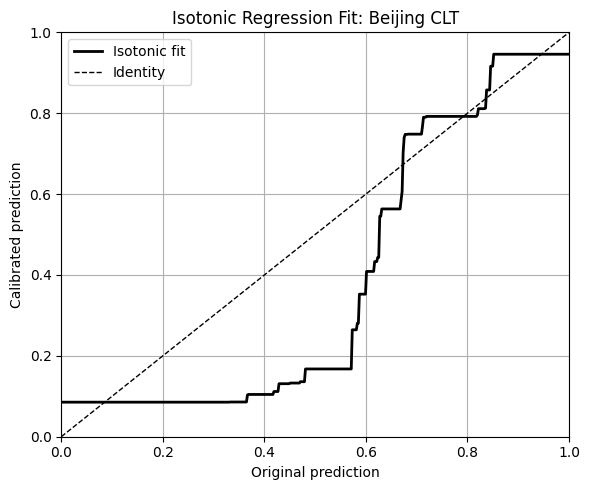

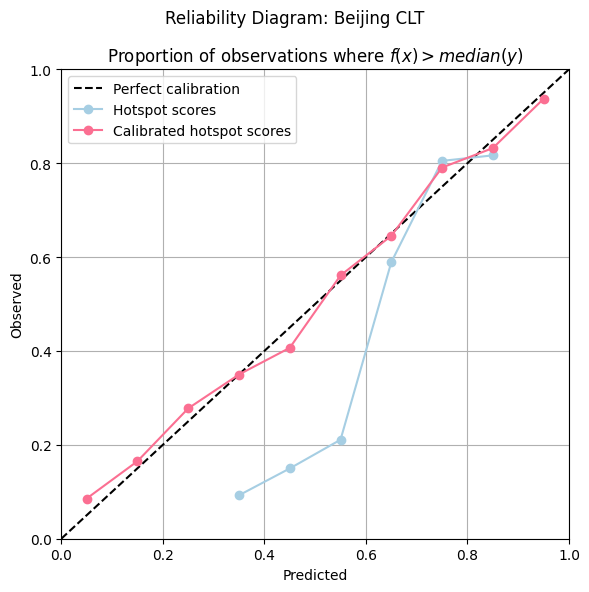

In [ ]:
improve_calibration(china_life_calibration_gp_train, china_life_calibration_gp_train_results, china_life_calibration_gp_test, title="Beijing CLT")


Saving data used for isotonic regression plot...
Expected Calibration Error before calibration: 0.2294
Brier score before calibration: 0.2270
Expected Calibration Error after calibration: 0.0441
Brier score after calibration: 0.1688

Data used for reliability plot:
 Bin center  Original proportion  Calibrated proportion
       0.05             0.081790               0.091122
       0.15             0.084867               0.127042
       0.25             0.098076               0.220573
       0.35             0.131379               0.286391
       0.45             0.177603               0.399272
       0.55             0.225604               0.447115
       0.65             0.314123               0.564164
       0.75             0.512600               0.697332
       0.85             0.597890               0.809256
       0.95             0.800604               0.961296


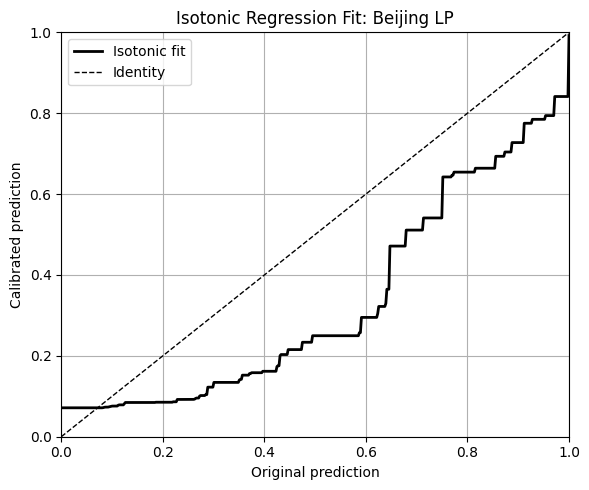

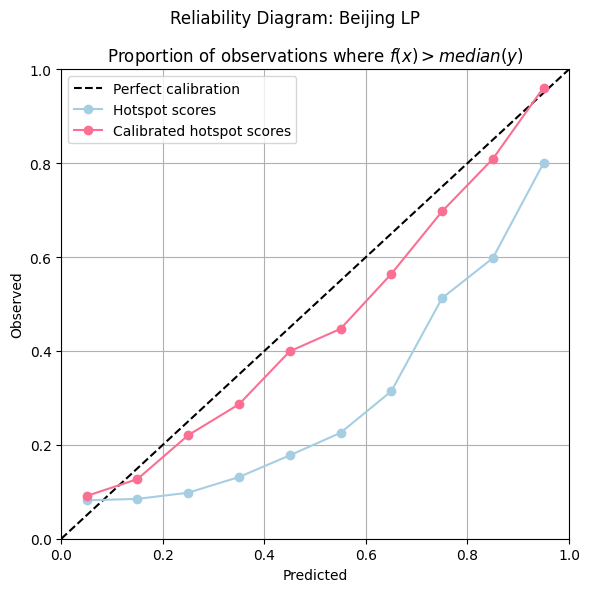

In [9]:
improve_calibration(longtan_park_calibration_gp_train, longtan_park_calibration_gp_train_results, longtan_park_calibration_gp_test, title="Beijing LP")

#### 3.c) Calibration data

In [10]:
df_plot_data_cl = pickle.load(open(rf"C:\Users\nial\Documents\GitHub\Air-Quality-Gaussian-Process\Paper Plots\Calibration\Beijing CLT_isotonic_regression.pkl", "rb"))
df_plot_data_lp = pickle.load(open(rf"C:\Users\nial\Documents\GitHub\Air-Quality-Gaussian-Process\Paper Plots\Calibration\Beijing LP_isotonic_regression.pkl", "rb")) 

In [27]:
df_plot_data_cl[(abs(df_plot_data_cl['Calibrated prediction'] - 0.945864) < 0.0001) & (df_plot_data_cl['Original prediction'] < df_plot_data_cl['Calibrated prediction'])]

,Original prediction,Calibrated prediction
425,0.851703,0.945864
426,0.853707,0.945864
427,0.855711,0.945864
428,0.857715,0.945864
429,0.859719,0.945864
430,0.861723,0.945864
431,0.863727,0.945864
432,0.865731,0.945864
433,0.867735,0.945864
434,0.869739,0.945864


In [24]:
df_plot_data_lp[df_plot_data_lp['Original prediction'] < df_plot_data_lp['Calibrated prediction']]

,Original prediction,Calibrated prediction
0,0.000000,0.071501
1,0.002004,0.071501
2,0.004008,0.071501
3,0.006012,0.071501
4,0.008016,0.071501
5,0.010020,0.071501
6,0.012024,0.071501
7,0.014028,0.071501
8,0.016032,0.071501
9,0.018036,0.071501
